LDA influenced by: http://sebastianraschka.com/Articles/2014_python_lda.html

In [161]:
import pandas as pd
df = pd.read_csv('data/player_team_counts.csv')

In [162]:
df.head()

,team_id,player_id,court_location,of_def_flag,count
0,1610612737,2594,2.0,def,14592.0
1,1610612737,2594,2.0,of,15093.0
2,1610612737,2594,3.0,def,6447.0
3,1610612737,2594,3.0,of,6215.0
4,1610612737,2594,4.0,def,5383.0


In [163]:
from utils import label_zones
df.court_location = label_zones(df.court_location)

In [164]:
import json
player_names_raw = json.load(open('data/players.json'))
player_names = {}
for d in player_names_raw:
    player_names[d['playerId']] = d['firstName'] + ' ' + d['lastName']
df.player_id = df.player_id.map(player_names)

team_names_raw = json.load(open('data/teams.json'))
team_names = {}
for d in team_names_raw:
    team_names[d['teamId']] = d['teamName']
        
df.team_id = df.team_id.map(team_names)

In [165]:
df.head()

,team_id,player_id,court_location,of_def_flag,count
0,Atlanta Hawks,Kyle Korver,"Right Side(R), 8-16 ft.",def,14592.0
1,Atlanta Hawks,Kyle Korver,"Right Side(R), 8-16 ft.",of,15093.0
2,Atlanta Hawks,Kyle Korver,"Right Side(R), 16-24 ft.",def,6447.0
3,Atlanta Hawks,Kyle Korver,"Right Side(R), 16-24 ft.",of,6215.0
4,Atlanta Hawks,Kyle Korver,"Right Side(R), 24+ ft.",def,5383.0


In [166]:
mat = df.groupby(['player_id', 'team_id', 'of_def_flag', 'court_location']).sum().unstack(fill_value=0.0)
mat.columns = df.court_location.unique()
mat.to_csv('data/player_team_counts_mat.csv')

In [167]:
df.groupby(['player_id', 'team_id', 'of_def_flag', 'court_location']).sum().unstack(fill_value=0.0)

count  \
court_location                                         Center(C), 16-24 ft.   
player_id           team_id                of_def_flag                        
Aaron Brooks        Chicago Bulls          def                       2891.0   
                                           of                        2465.0   
Aaron Gordon        Orlando Magic          def                       6135.0   
                                           of                        7176.0   
Adreian Payne       Minnesota Timberwolves def                       2904.0   
                                           of                        4253.0   
Al Horford          Atlanta Hawks          def                      19429.0   
                                           of                       18573.0   
Al Jefferson        Charlotte Hornets      def                       6379.0   
                                           of                        5488.0   
Al-Farouq Aminu     Portland Trail Blazers def                      10233.0   
                                           of                        9868.0   
Alec Burks          Utah Jazz              def                       5057.0   
                                           of                        4878.0   
Alex Len            Phoenix Suns           def                      11497.0   
                                           of                        9619.0   
Alexis Ajinca       New Orleans Pelicans   def                       5602.0   
                                           of                        7216.0   
Allen Crabbe        Portland Trail Blazers def                       7023.0   
                                           of                        6698.0   
Amir Johnson        Boston Celtics         def                      13918.0   
                                           of                       13634.0   
Andre Drummond      Detroit Pistons        def                      21811.0   
                                           of                       22353.0   
Andre Iguodala      Golden State Warriors  def                       8922.0   
                                           of                        7910.0   
Andre Roberson      Oklahoma City Thunder  def                       5087.0   
                                           of                        6571.0   
Andrew Bogut        Golden State Warriors  def                       7235.0   
                                           of                        8269.0   
...                                                                     ...   
Tyreke Evans        New Orleans Pelicans   def                       4671.0   
                                           of                        4950.0   
Tyson Chandler      Phoenix Suns           def                       9301.0   
                                           of                       10631.0   
Tyus Jones          Minnesota Timberwolves def                        633.0   
                                           of                         712.0   
Udonis Haslem       Miami Heat             def                       2675.0   
                                           of                        2151.0   
Victor Oladipo      Orlando Magic          def                       6991.0   
                                           of                        6852.0   
Vince Carter        Memphis Grizzlies      def                       3882.0   
                                           of                        2838.0   
Wayne Ellington     Brooklyn Nets          def                       3971.0   
                                           of                        3464.0   
Wesley Johnson      Los Angeles Clippers   def                       4987.0   
                                           of                        5639.0   
Wesley Matthews     Dallas Mavericks       def                       7844.0   
                                         

In [261]:
mat_of = mat.xs('of', level = 2)
player, team = zip(*mat_of.index.tolist())

i = 0
unique_team= {}
labels = {}
for t in team:
    if t not in unique_team:
        i += 1
        unique_team[t] = i
        labels[i] = t
team_ids = [unique_team[t] for t in team]

In [262]:
mat_of_norm = mat_of.div(mat_of.sum(axis=1), axis=0)

In [263]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=14)

X_lda_sklearn = sklearn_lda.fit_transform(mat_of_norm.as_matrix(), team_ids)


/Users/sam/miniconda3/envs/data_cleaning/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/sam/miniconda3/envs/data_cleaning/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [264]:
def plot_scikit_lda(X, y, title, labels, label_dict, ax, ids_subset, players_subset):

    for label in ids_subset:
        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    alpha=0.5,
                    label=label_dict[label])
    for player_label, player_xy in players_subset:
        ax.annotate(player_label, xy = player_xy)

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper left', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)  

In [265]:
players_cavs, of = zip(*mat.xs('Cleveland Cavaliers', level = 1).index.tolist())
players_mn, of = zip(*mat.xs('Minnesota Timberwolves', level = 1).index.tolist())
players_tx, of = zip(*mat.xs('Houston Rockets', level = 1).index.tolist())
players_sf, of = zip(*mat.xs('Golden State Warriors', level = 1).index.tolist())

In [266]:
# players_locs = X[:,0]
# selected_players = ['James Harden', 'Stephen Curry', 'Klay Thompson', 'Andrew Wiggins', 'Karl-Anthony Towns',
#                    'Zach LaVine', 'Ricky Rubio', 'Draymond Green', 'Andrew Bogut', 'Andre Iguodala', 'LeBron James',
#                    'Kyrie Irving', 'JR Smith']
selected_players_locs = []
filter_ps = ['Ian Clark', 'Marreese Speights', 'Timofey Mozgov', 'Tristan Thompson', 'Joe Harris']
for p in players_cavs+players_mn+players_tx+players_sf:
    if p in filter_ps:
        continue
    try:
        i = player.index(p)
    except:
        None
    d = X_lda_sklearn[i]
    x = d[0]
    y = d[1] * -1
    selected_players_locs.append((p, (x, y)))    
# player_locs = list(zip(player, list(zip(X_lda_sklearn[:,0].tolist(), X_lda_sklearn[:,1].tolist()))))

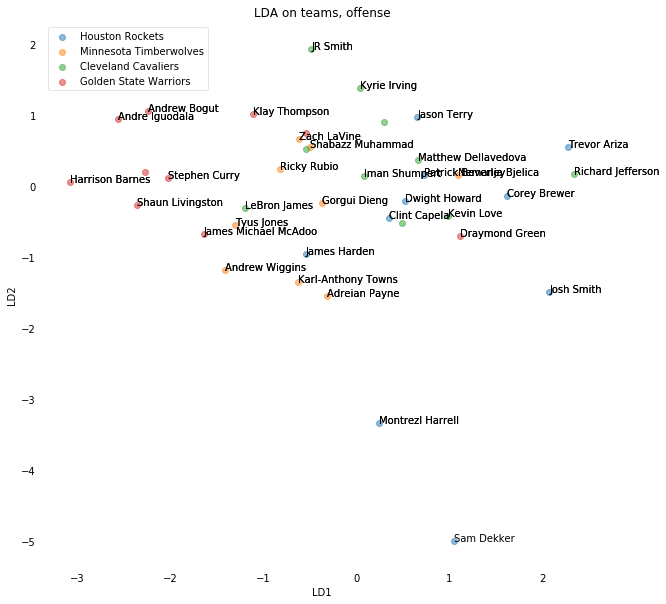

In [267]:
# plt.grid()
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_scikit_lda(X_lda_sklearn, pd.Series(team_ids), "LDA on teams, offense", set(team_ids), 
                labels, ax, [25, 3, 29, 12], selected_players_locs)
plt.show()
plt.savefig('report/LDA_players_teams_offense.png')

In [239]:
list(player).index('James Harden')

119

In [135]:
player_locs[0:2]

[('Aaron Brooks', (-0.0371451749257125, -1.043259100634034)),
 ('Aaron Gordon', (-0.23983613852186317, 0.23876781726123789))]